## Hypothesis testing

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("telco_preprocessed.csv", index_col=0)

In [7]:
from scipy.stats import ttest_ind

## Loop for performing two-sample t-tests
# df1: sample 1
# df2: sample 2 
# split_col: the column used to split the dataset into df1 and df2
def t_test_loop(df1, df2, split_col):
    cols = df1.columns.values.tolist()
    cols.remove(split_col)
    tstatistics = []
    pvalues = []
    for col in cols:
        res = ttest_ind(df1[col], df2[col])
        tstatistics.append(res.statistic)
        pvalues.append(res.pvalue)
        #print("{} : t-statistic: {:.2f} p-value: {:.2f}".format(col, res.statistic, res.pvalue))

    d = {'t-statistic': tstatistics, 'p-value': pvalues}
    res_df = pd.DataFrame(data=d, index=cols)
    return res_df

In [8]:
from scipy import stats

## Function for performing a two-sample, two-sided proportion test
# df1: sample 1
# df2: sample 2
def proportion_test(df1, df2):
    n1 = len(df1)
    n2 = len(df2)
    n = n1 + n2
    
    p1 = np.mean(df1)
    p2 = np.mean(df2)
    
    Y1 = p1*n1
    Y2 = p2*n2
    
    p = (Y1+Y2)/(n1+n2)
        
    z_statistic = (p1-p2)/(np.sqrt(p*(1-p)*(1/n1+1/n2)))
    
    p_value = stats.norm.sf(abs(z_statistic))*2

    return z_statistic, p_value

In [9]:
def test_loop(df1, df2, cols):
    for col in cols:
        print(proportion_test(df1[col], df2[col]))

**Testing males vs. females**

In [10]:
males = df[df["gender"] == 1]
females = df[df["gender"] == 0]

In [11]:
colz = ["streaming_movies", "tech_support", "online_backup", "device_protection", "churn"]
test_loop(males, females, colz)

(-0.880126033491207, 0.3787910374756692)
(-0.7730747265379251, 0.4394781573950589)
(-1.1558815794222248, 0.24772959823049623)
(-0.1766220130265633, 0.8598053020265863)
(-0.7227492672834878, 0.4698339411426554)


Based on the results of these tests, we can conclude that there is no difference between males and females when it comes to subscribing to the four services above.

We also see that there is no significant difference between males and females when it comes to proportion that churns.

**Testing senior vs. non-seniors**

In [12]:
seniors = df[df["senior"] == 1] 
non_seniors = df[df["senior"] == 0]

In [13]:
test_loop(seniors, non_seniors, colz)

(10.08550145986188, 6.40373644138926e-24)
(-5.087772266935232, 3.6229404677849735e-07)
(5.586905562036917, 2.3115134031254545e-08)
(4.987392766527645, 6.119956782554342e-07)
(12.663022223987696, 9.477903507376036e-37)


In [14]:
print(np.mean(seniors.tech_support), np.mean(non_seniors.tech_support))

0.2276707530647986 0.3023216403999322


When we compare customers that are senior citizen with those that are not, all the tests are significant. More specifically, we can conclude that the proportion of senior customers that subscribe to movie streaming, online backup and device protection are higher than for non-senior customers. The proportion of senior customers that subscribe to tech support is *lower* than the proportion of non-senior customers subscribing to tech support, which is a bit surprising.

We can also see that the proportion of churn is significantly greater for senior citizen than for non-senior citizen. One explanation might be that senior citizen are old and some therefore pass away, which ends their subscription (lol).

In [15]:
cols1 = df.columns.values.tolist()
rem = ["tenure", "monthly_charges", "total_charges", "churn"]
for el in rem: 
    cols1.remove(el)

In [20]:
def calc_prop(df, cols):
    c0 = []
    c1 = []
    for col in cols: 
        cat0 = df[df[col] == 0]
        cat1 = df[df[col] == 1]

        c0.append(np.mean(cat0["churn"]))
        c1.append(np.mean(cat1["churn"]))
        
    d = {'No': c0, 'Yes': c1}
    prop_df = pd.DataFrame(data=d, index=cols)
    return prop_df

In [40]:
proportions = calc_prop(df, cols1)

In [52]:
proportions.sort_values(by="Yes", inplace=True)

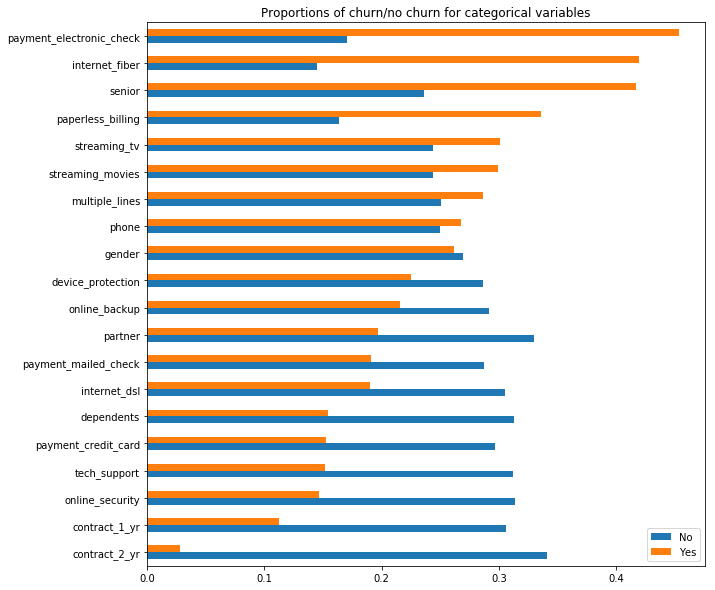

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = proportions.plot.barh(figsize=(10,10), 
                           title="Proportions of churn/no churn for categorical variables")

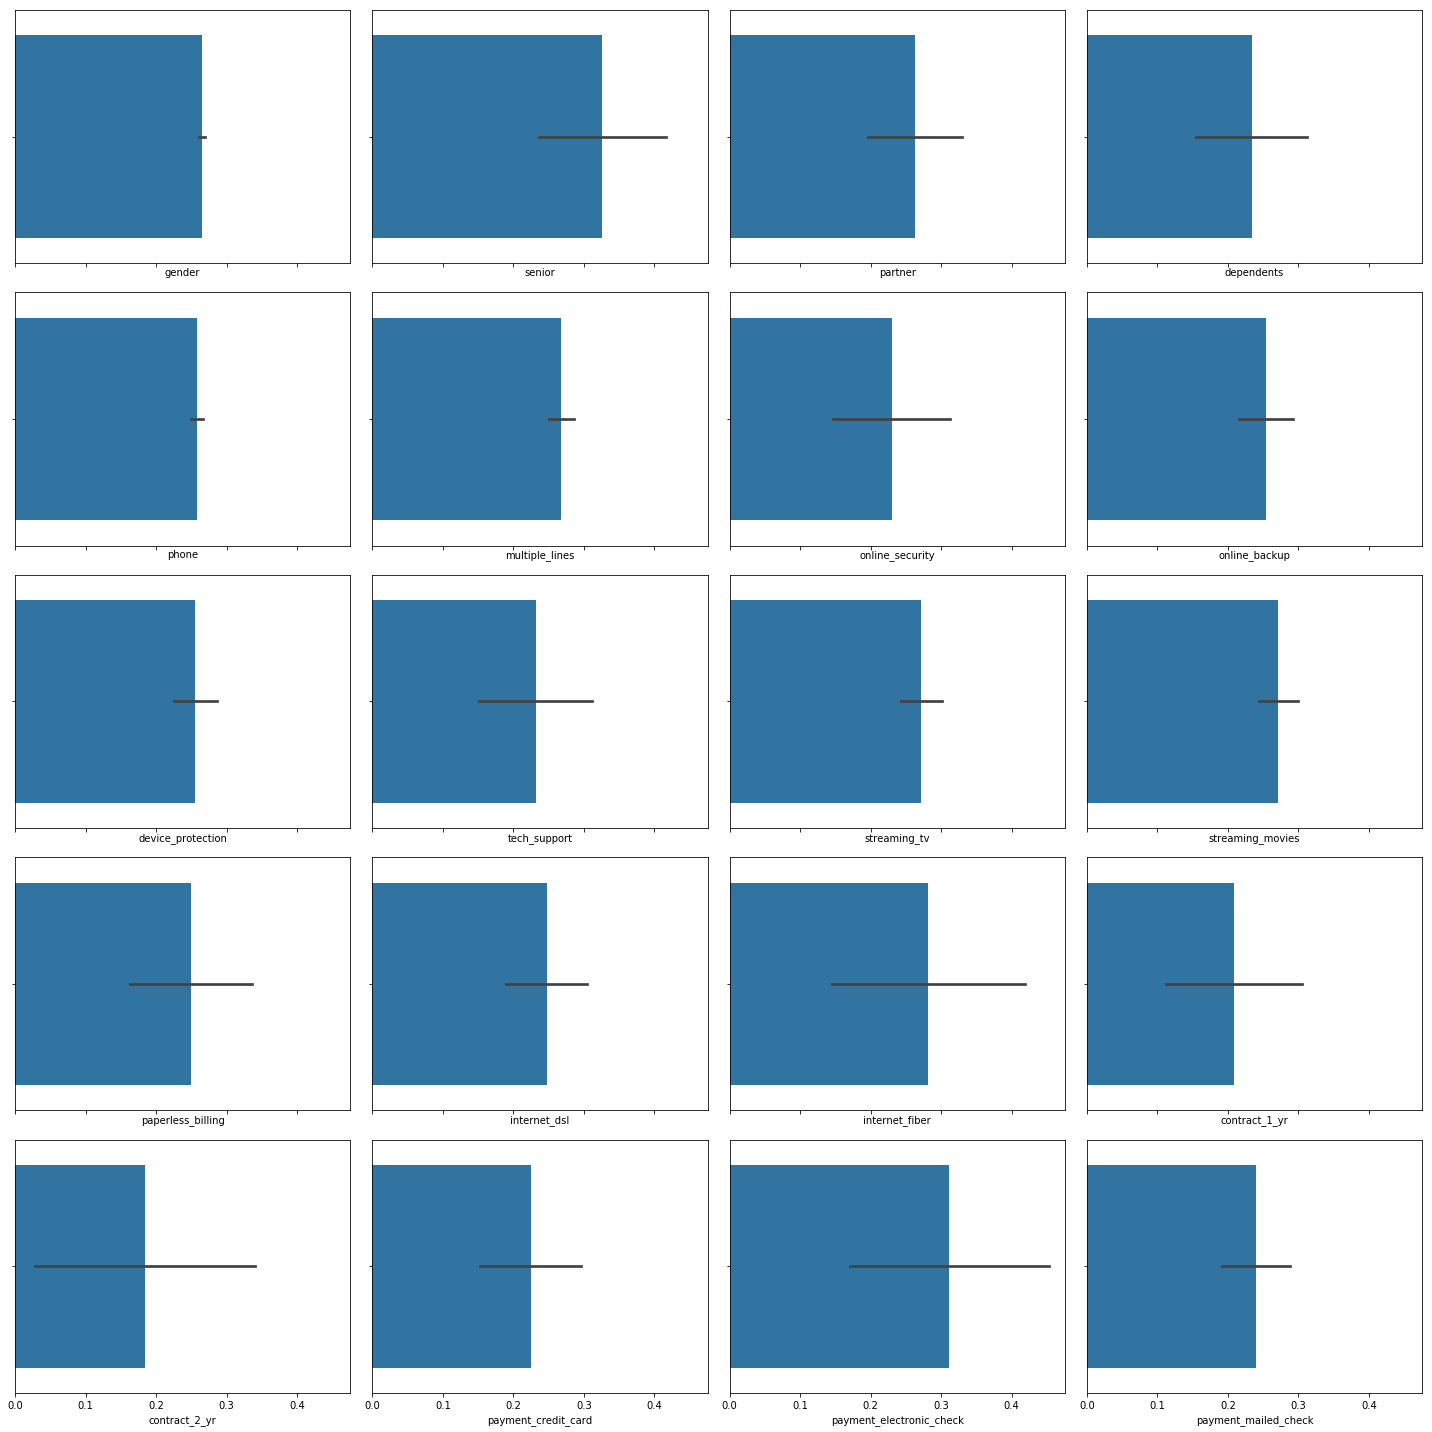

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = proportions.columns.values.tolist()

fig, axes = plt.subplots(5, 4, figsize=(20,20), sharex=True)
axes = axes.flatten()
for ax, col in zip(axes, cols): 
    sns.barplot(x=col, data=proportions, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
## https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        
# lr1 = LogisticReg(solver="lbfgs", random_state=0)
# lr1.fit(X,y)
# z = lr1.z_scores
# p = lr1.p_values
# zipped = list(zip(list(features), z, p))
# lr1_summary = pd.DataFrame(zipped)
# lr1_summary